In [1]:
from pycalphad.core.solver import SolverBase, SolverResult, InteriorPointSolver

class NoOpSolver(SolverBase):
    ignore_convergence = True
    @staticmethod
    def solve(prob):
        return SolverResult(converged=False, x=prob.x0, chemical_potentials=None)
fastsolver = NoOpSolver()
ipsolver = InteriorPointSolver(verbose=False)

In [14]:
from pycalphad import Database, equilibrium, variables as v

dbf = Database('alzn_mey.tdb')

num_runs = 10
comps = ['AL', 'ZN', 'VA']
conds = {v.T: (300,1000,100), v.X('AL'): 0.7, v.P: 101325}
phases = sorted(dbf.phases.keys())

# Prime the cache
eq = equilibrium(dbf, comps, phases, conds, solver=fastsolver)

In [15]:
import time

start = time.perf_counter()

for _ in range(num_runs):
    eq_exact = equilibrium(dbf, comps, phases, conds, solver=ipsolver)
exact_tx = (time.perf_counter() - start) / num_runs

In [16]:
import numpy as np
results = []
for pdens in [10, 50, 100, 200, 300, 400, 500, 1000, 2000]:
    start = time.perf_counter()
    for _ in range(num_runs):
        eq = equilibrium(dbf, comps, phases, conds, solver=fastsolver, calc_opts={'pdens': pdens})
    tx = (time.perf_counter() - start) / num_runs
    error = np.abs((eq.MU - eq_exact.MU) / (8.3145 * eq['T']))
    results.append((pdens, exact_tx / tx, np.max(error), np.mean(error)))

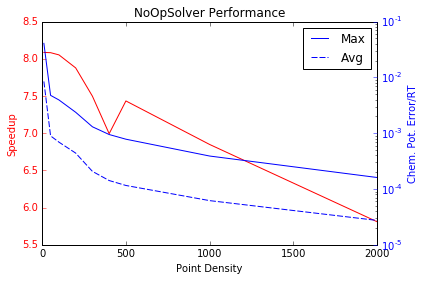

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
pdens, tx, max_err, mean_err = zip(*results)

fig = plt.figure()
ax1 = fig.gca()
ax1.set_title('NoOpSolver Performance')
ax1.set_ylabel('Speedup', color='r')
ax1.plot(pdens, tx, color='r')
ax1.tick_params('y', colors='r')
ax1.set_xlabel('Point Density')

ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.set_ylabel('Chem. Pot. Error/RT', color='b')
ax2.plot(pdens, max_err, color='b', label='Max')
ax2.plot(pdens, mean_err, color='b', dashes=[6,2], label='Avg')
ax2.tick_params('y', colors='b')
ax2.legend(loc='best')